In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Compute forecast accuarcy measures
from sklearn.metrics import mean_squared_error

- Useful links:
    - https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
    - https://otexts.com/fpp2/ses.html 

In [2]:
#ts = [65, 78, 75, 102, 91, 115, 105, 135, 121, 156]
#df_ts = pd.DataFrame(data=ts, columns=["ts"])
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df_ts = pd.read_csv(url, index_col='Month', parse_dates=True)
df_ts

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


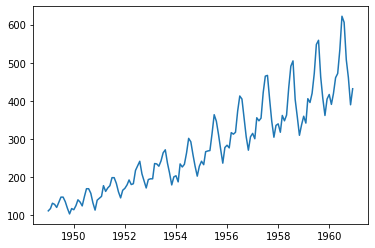

In [76]:
plt.plot(df_ts)

## Decomposing time-series

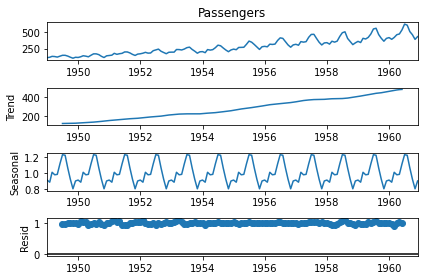

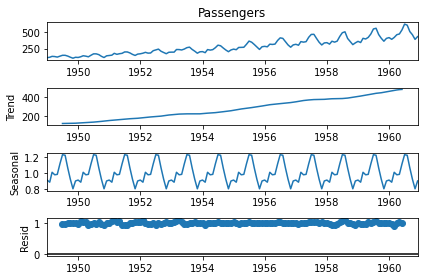

In [23]:
seasonal_decompose(df_ts['Passengers'],model="multiplicative").plot()

## ACF and PACF calculations

In [40]:
def plot_acf_pacf(df_ts, lags=12):
    print(plot_acf(df_ts, lags=lags))
    print(plot_pacf(df_ts, lags=lags, method="ols"))

In [14]:
print("calculating autocorrelations: ", sm.tsa.acf(df_ts, nlags=4, fft=False))

calculating autocorrelations:  [1.         0.94804734 0.87557484 0.80668116 0.75262542]


In [17]:
print("calculating pacf through ols: ", sm.tsa.pacf(df_ts, nlags=12, method="ols"))

calculating pacf through ols:  [ 1.          0.95893198 -0.32983096  0.2018249   0.14500798  0.25848232
 -0.02690283  0.20433019  0.15607896  0.56860841  0.29256358  0.8402143
  0.61268285]


Figure(432x288)
Figure(432x288)


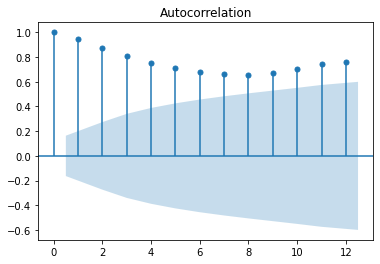

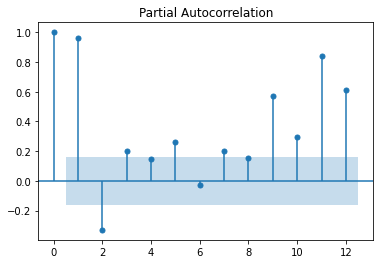

In [42]:
plot_acf_pacf(df_ts)

## Check stationarity

In [28]:
def check_stationarity(values):
    result=adfuller(values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [52]:
check_stationarity(df_ts)

ADF Statistic: 0.815369
p-value: 0.991880
	1%: -3.482
	5%: -2.884
	10%: -2.579


- Stabilize Variance

In [74]:
df_logged_ts = np.log(df_ts)
check_stationarity(df_logged_ts)

ADF Statistic: -1.717017
p-value: 0.422367
	1%: -3.482
	5%: -2.884
	10%: -2.579


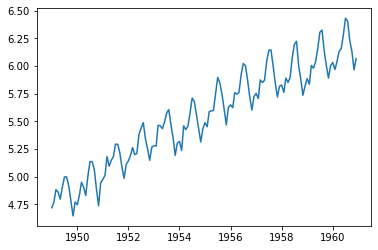

In [75]:
plt.plot(df_logged_ts)

- Stabilize mean over time

In [78]:
n_diff = 1
df_log_diff = df_logged_ts.diff(n_diff).values[n_diff:]
check_stationarity(df_log_diff)

ADF Statistic: -2.717131
p-value: 0.071121
	1%: -3.483
	5%: -2.884
	10%: -2.579


- Plot ACF and PACF after log transformation and differenciating

Figure(432x288)
Figure(432x288)


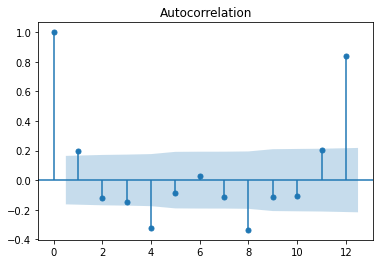

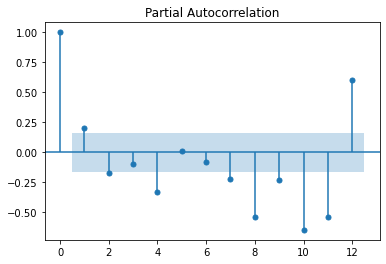

In [79]:
plot_acf_pacf(df_log_diff)

## Modeling with ARIMA

In [80]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_ts, order=(2,1,1))
model_fit = model.fit()

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


## Autoregressive processes

In [11]:
steps=1000
phi_t1 = 0.7
phi_t2 = 0.4

e = np.random.randn(steps)
y = [0]
y_t1 = []

for i in range(len(e)):
    y.append(phi_t1*y[i]+phi_t2*y[i]+e[i])


df = pd.DataFrame(y, columns=["y"])
df["y_1"] = df["y"].shift()

In [6]:
import numpy as np
(23.8-23)/(4.8/np.sqrt(80))

1.4907119849998614

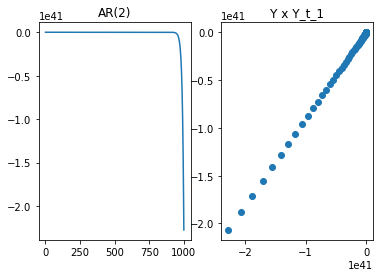

In [12]:
plt.subplot(1, 2, 1) 
plt.title("AR(2)")
plt.plot(df["y"])

plt.subplot(1, 2, 2)
plt.title("Y x Y_t_1")
plt.scatter(df["y"], df["y_1"])

plt.show()

###### Try using y_t2 = 0.4, is non-stationary and the graph will explode

# Wheat prices

### Exponential smoothing methods

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
path = "/Users/gabrieldiasmp/Documents/pasta_gabriel/masters/time_series/time-series-project/Datasets/PWHEAMTUSDM.xls"
df_wheat = pd.read_excel(path, index_col="observation_date").rename(columns={"PWHEAMTUSDM": "wheat_price"})
df_wheat["observation_date"] = df_wheat.index

In [3]:
### Last training date
df_wheat.iloc[314]

wheat_price                  164.060472
observation_date    2016-03-01 00:00:00
Name: 2016-03-01 00:00:00, dtype: object

In [4]:
# Train and Test data Splitting
df_train = df_wheat.iloc[:314]
df_test = df_wheat.iloc[314:]

In [5]:
df_test.shape

(79, 2)

In [24]:
df_train.columns

Index(['wheat_price'], dtype='object')

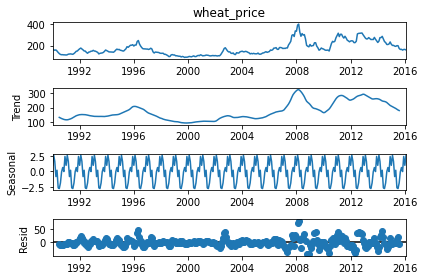

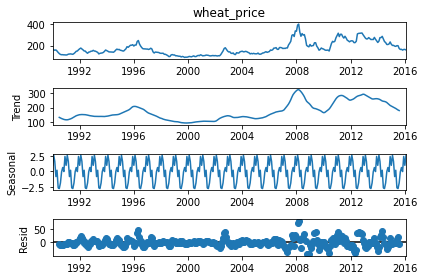

In [6]:
seasonal_decompose(df_train['wheat_price']).plot()

In [28]:
decompositions = seasonal_decompose(df_train['wheat_price'])

In [33]:
decompositions.seasonal[:24]

observation_date
1990-01-01    0.960824
1990-02-01    2.600454
1990-03-01    1.614059
1990-04-01   -0.856371
1990-05-01    0.168621
1990-06-01   -2.675396
1990-07-01   -2.793446
1990-08-01   -1.884209
1990-09-01   -0.092183
1990-10-01    0.606748
1990-11-01   -0.045411
1990-12-01    2.396309
1991-01-01    0.960824
1991-02-01    2.600454
1991-03-01    1.614059
1991-04-01   -0.856371
1991-05-01    0.168621
1991-06-01   -2.675396
1991-07-01   -2.793446
1991-08-01   -1.884209
1991-09-01   -0.092183
1991-10-01    0.606748
1991-11-01   -0.045411
1991-12-01    2.396309
Name: seasonal, dtype: float64

- Simple exponential smoothing method

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


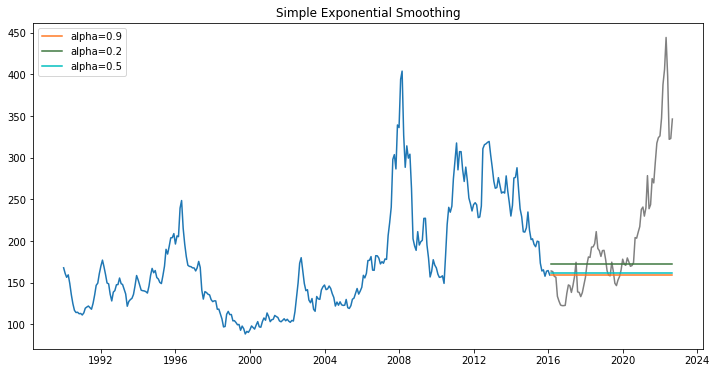

In [34]:
length_forecast = df_test.shape[0]

model_single = SimpleExpSmoothing(df_train['wheat_price'], initialization_method="estimated")
fit1 = model_single.fit()
pred1 = fit1.forecast(length_forecast)
fit2 = model_single.fit(smoothing_level=.2)
pred2 = fit2.forecast(length_forecast)
fit3 = model_single.fit(smoothing_level=.5)
pred3 = fit3.forecast(length_forecast)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_train["observation_date"], df_train["wheat_price"])
ax.plot(df_test["observation_date"], df_test["wheat_price"], color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(df_test["observation_date"], p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();

In [8]:
# Forecast Accuracy Measures: alpha=0.2
rmse = round(np.sqrt(mean_squared_error(df_test["wheat_price"],pred2)),2)
print("Root Mean Squared Error (RMSE) =",rmse)


Root Mean Squared Error (RMSE) = 80.32


- Holt's method

In [11]:
holt = ExponentialSmoothing(
    df_train['wheat_price'],
    trend='add'
).fit()
holt_predictions = holt.forecast(df_test.shape[0]).rename('Holt Forecast')

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


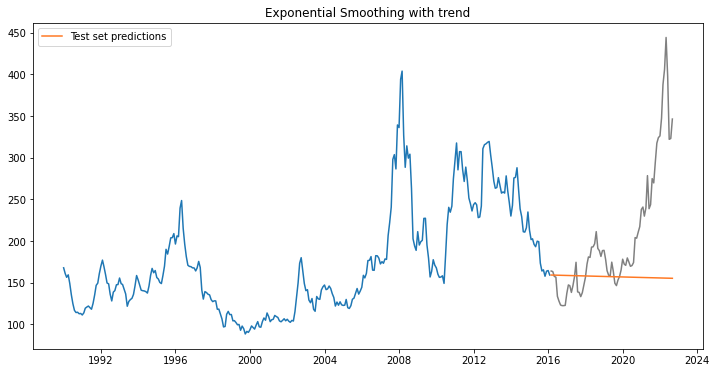

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_train["observation_date"], df_train["wheat_price"])
ax.plot(df_test["observation_date"], df_test["wheat_price"], color="gray")
ax.plot(df_test["observation_date"], holt_predictions, label="Test set predictions", color='#ff7823')

plt.title("Exponential Smoothing with trend")  
  
plt.legend();

In [13]:
# Forecast Accuracy Measures
rmse = round(np.sqrt(mean_squared_error(df_test["wheat_price"],holt_predictions)),2)
print("Root Mean Squared Error (RMSE) =",rmse)

Root Mean Squared Error (RMSE) = 87.91


- Holt Winter's method

In [35]:
holt = ExponentialSmoothing(
    df_train['wheat_price'],
    trend='add', 
    seasonal="add", 
    seasonal_periods=12
).fit()
holt_predictions = holt.forecast(df_test.shape[0]).rename('Holt Winters Forecast')


/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


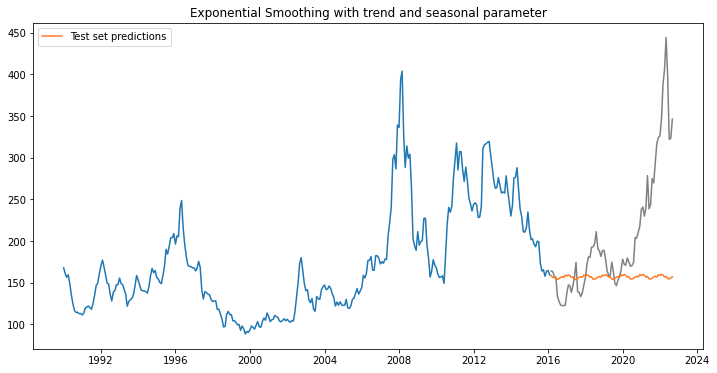

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_train["observation_date"], df_train["wheat_price"])
ax.plot(df_test["observation_date"], df_test["wheat_price"], color="gray")
ax.plot(df_test["observation_date"], holt_predictions, label="Test set predictions", color='#ff7823')

plt.title("Exponential Smoothing with trend and seasonal parameter")  
  
plt.legend();

In [37]:
# Forecast Accuracy Measures
rmse = round(np.sqrt(mean_squared_error(df_test["wheat_price"],holt_predictions)),2)
print("Root Mean Squared Error (RMSE) =",rmse)

Root Mean Squared Error (RMSE) = 87.13


In [38]:
holt = ExponentialSmoothing(
    df_wheat["wheat_price"],
    trend='add', 
    seasonal="add", 
    seasonal_periods=12
).fit()
holt_forecasts = holt.forecast(24).rename("Holt Winters Forecast")

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


- Forecast next values with Holt Winters method

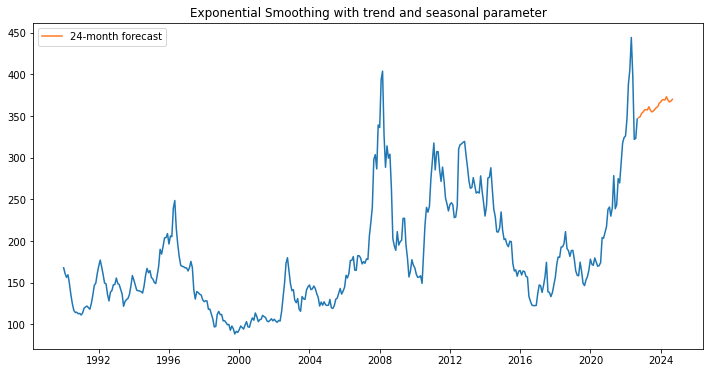

In [39]:
# Holt Winters
holt = ExponentialSmoothing(
    df_wheat["wheat_price"],
    trend='add', 
    seasonal="add", 
    seasonal_periods=12
).fit()
holt_forecasts = holt.forecast(24).rename("Holt Winters Forecast")

# Plotting the forecasted values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_wheat["observation_date"], df_wheat["wheat_price"])
ax.plot(holt_forecasts.index, holt_forecasts, label="24-month forecast", color='#ff7823')

plt.title("Exponential Smoothing with trend and seasonal parameter")  
  
plt.legend();